In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
df = pd.read_csv("customer_payment_6to12months.csv")
print("Data loaded:", df.shape)
print(df.head())

Data loaded: (13596, 5)
   customer_id  month  on_time_payment  spend_ratio  late_days
0            1      1                1        0.655          0
1            1      2                0        0.624          3
2            1      3                0        0.675          5
3            1      4                1        0.742          0
4            1      5                1        0.664          0


In [5]:
SEQ_LEN = 6
features = ['on_time_payment', 'spend_ratio', 'late_days']

sequences, labels, cust_ids = [], [], []

for cid, group in df.groupby('customer_id'):
    group = group.sort_values('month').reset_index(drop=True)
    if len(group) < SEQ_LEN + 1:
        continue
    for start in range(0, len(group) - SEQ_LEN):
        window = group.iloc[start:start+SEQ_LEN]
        target = group.iloc[start+SEQ_LEN]
        seq_arr = window[features].values.astype(float)
        seq_arr[:, 2] = seq_arr[:, 2] / 10.0   # scale down late_days
        sequences.append(seq_arr)
        labels.append(0 if target['on_time_payment'] == 1 else 1)
        cust_ids.append(cid)

X = np.array(sequences)
y = np.array(labels)
cust_ids = np.array(cust_ids)
print("Total sequences:", X.shape, "Positive rate:", y.mean())

Total sequences: (4596, 6, 3) Positive rate: 0.37554395126196694


In [6]:
unique_customers = np.unique(cust_ids)
train_c, test_c = train_test_split(unique_customers, test_size=0.2, random_state=42)
train_c, val_c = train_test_split(train_c, test_size=0.125, random_state=42)  # ≈10% validation overall

def split_by_customers(X, y, cust_ids, cust_list):
    mask = np.isin(cust_ids, cust_list)
    return X[mask], y[mask]

X_train, y_train = split_by_customers(X, y, cust_ids, train_c)
X_val, y_val = split_by_customers(X, y, cust_ids, val_c)
X_test, y_test = split_by_customers(X, y, cust_ids, test_c)

print("Train/Val/Test:", X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test: (3204, 6, 3) (475, 6, 3) (917, 6, 3)


In [7]:
tf.random.set_seed(42)
model = Sequential([
    Masking(mask_value=0., input_shape=(SEQ_LEN, len(features))),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='AUC')])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 6, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=128,
    callbacks=[es],
    verbose=2
)


Epoch 1/25
26/26 - 7s - 267ms/step - AUC: 0.5514 - loss: 0.6607 - val_AUC: 0.6851 - val_loss: 0.6194
Epoch 2/25
26/26 - 0s - 14ms/step - AUC: 0.6840 - loss: 0.6269 - val_AUC: 0.7154 - val_loss: 0.5906
Epoch 3/25
26/26 - 0s - 13ms/step - AUC: 0.6849 - loss: 0.6150 - val_AUC: 0.7284 - val_loss: 0.5785
Epoch 4/25
26/26 - 0s - 13ms/step - AUC: 0.6873 - loss: 0.6117 - val_AUC: 0.7319 - val_loss: 0.5747
Epoch 5/25
26/26 - 0s - 15ms/step - AUC: 0.6933 - loss: 0.6087 - val_AUC: 0.7419 - val_loss: 0.5704
Epoch 6/25
26/26 - 0s - 14ms/step - AUC: 0.6980 - loss: 0.6059 - val_AUC: 0.7463 - val_loss: 0.5660
Epoch 7/25
26/26 - 1s - 24ms/step - AUC: 0.7024 - loss: 0.6030 - val_AUC: 0.7525 - val_loss: 0.5616
Epoch 8/25
26/26 - 0s - 13ms/step - AUC: 0.7072 - loss: 0.6000 - val_AUC: 0.7589 - val_loss: 0.5571
Epoch 9/25
26/26 - 0s - 13ms/step - AUC: 0.7128 - loss: 0.5968 - val_AUC: 0.7621 - val_loss: 0.5529
Epoch 10/25
26/26 - 0s - 14ms/step - AUC: 0.7165 - loss: 0.5938 - val_AUC: 0.7640 - val_loss: 0.549

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Test AUC: 0.7599
Test F1-score: 0.5938

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.86      0.80       567
           1       0.69      0.52      0.59       350

    accuracy                           0.73       917
   macro avg       0.72      0.69      0.69       917
weighted avg       0.72      0.73      0.72       917


Confusion Matrix:
 [[486  81]
 [168 182]]


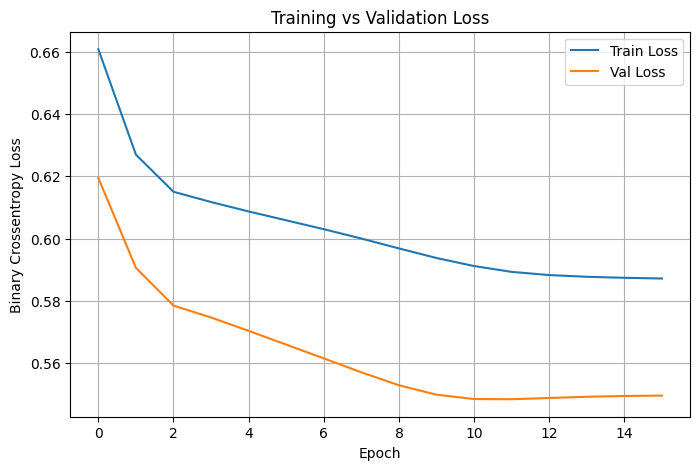

In [9]:
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred)
print(f"\nTest AUC: {auc:.4f}")
print(f"Test F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ===============================================
# STEP 8. Plot training vs validation loss
# ===============================================
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.show()